# Machine Learning - Project 2:
# _Unsteady parametrized Stokes equations in a 2D arterial bifurcation with stenosis: design of a Feed-Forward Autoencoder for data compression_

## Context

Our project aims at investigating the relationship between classical numerical methods and deep-learning techniques, with the final purpose of efficiently providing accurate solutions to parametrized PDE problems, being fully unaware of the values of the characteristic parameters. The professor's Deparis lab has developed efficient numerical methods for the resolution of parametrized time-dependent PDEs. In the following, we develop deep-learning models that take advantage of these numerical methods to solve parametrized unsteady PDEs without any knowledge of the characteristic parameters.

In this notebook, we make progress to this end by proposing deep-learning approaches to identify and evolve a low-dimensional representation of a spatiotemporal system. In particular, we employ PyTorch __Feed-Forward AEs__ to learn an optimal low-dimensional representation of the full state of the system. The notebook `lstm_main.ipynb` continues our analysis by focusing on _LSTM AEs_.

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. Autoencoder](#autoencoder)

[5. Physical interpretation](#physical)

[6. Discussion & conclusion](#ccl)

## 1. Data exploration  <a name="data_exploration"></a>

### Imports  <a name="1imports"></a>

In [16]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from autoencoder import *
from crossvalidation import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)
np.random.seed(1)
seed = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


If you have already saved the pickle files, you can already jump [here](#start_pickle)!

### Pathways <a name="1pathways"></a>

In [71]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_very_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_very_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [72]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [73]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (137725, 110)
Our input array Uy is of shape: (137725, 110)
Printing a row of Ux: 
 [0.0694243  0.27537487 0.60389834 1.02538242 1.49979277 1.9813229
 2.42318455 2.78232553 3.02371067 3.12378595 3.22605803 3.32166836
 3.41249686 3.49946177 3.58301614 3.66339786 3.74073801 3.81511138
 3.88656184 3.95511576 4.02078945 4.08359325 4.14353388 4.20061589
 4.2548424  4.30621561 4.35473712 4.40040807 4.44322934 4.48320158
 4.52032526 4.55460075 4.58602833 4.61460821 4.64034055 4.66322547
 4.68326307 4.70045341 4.71479655 4.72629252 4.73494137 4.7407431
 4.74369775 4.74423086 4.74375285 4.74246986 4.74042825 4.73764939
 4.73414407 4.72991811 4.7249748  4.71931611 4.71294324 4.70585693
 4.6980577  4.68954587 4.68032167 4.67038525 4.65973675 4.64837623
 4.63630377 4.6235194  4.61002317 4.5958151  4.5808952  4.5652635
 4.54892001 4.53186473 4.51409767 4.49561883 4.47642823 4.45652585
 4.43591171 4.41458581 4.39254814 4.36979872 4.34633752 4.32216457
 4.29727986 4.27

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated the number of simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [74]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at", positions, "different positions and at", times, "different times")

We ran  25 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at  5509  different positions and at  110  different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [75]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

Let's sample our data points into the following ratio. 

In [76]:
ratio_pts = 0.1
ratio_time = 0.5

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(13750, 55) (13750, 55)


In [77]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from', 5509, 'positions to', new_Nu, 'positions')
print('With the sampling we got from', 110, 'time steps to', new_Nt, 'time steps')

With the sampling we got from  5509  positions to  550  positions
With the sampling we got from  110  time steps to  55  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery.

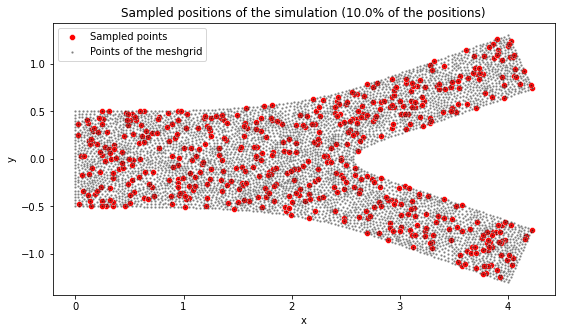

In [78]:
plot_sampled_coord(new_inds) 

Let's flatten our matrices into a single matrix with dimensions $(N_s, (2 N_u N_t))$. For each simulation, the x and y speed coordinates are compressed to the following 1D matrix:

$$
\mathbf{M_{1D}}
=
\begin{bmatrix}
\vdots \\
u_{x}^{(0)} \\
\vdots \\
u_{y}^{(0)} \\
\vdots \\
u_{x}^{(1)} \\
\vdots \\
u_{y}^{(1)} \\
\vdots \\
u_{x}^{(N_t - 1)} \\
\vdots \\
u_{y}^{(N_t - 1)} \\
\vdots 
\end{bmatrix}
$$



In [80]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 60500)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u}}$.

In [81]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

60500


## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle. 

In the following cell, we will create pickles for every subsampled data according to the ratios_pts and the ratios_t.

In [14]:
'''
ratios_pts = [0.1, 0.05, 0.02]
ratios_t = [0.5, 0.25, 0.1]

create_subsamples(Ux, Uy, ratios_pts, ratios_t, name_file='middle_small')
'''

The cell above is only intented to be run __once__.

#### Start from here if you the pickle file already exist in your data folder <a name="start_pickle"></a>

Change only the following cell to change the name of the file you want to open.

In [2]:
ratios = [0.1, 0.5]
size = ['very_small', 'middle_small', 'small']

name = 'processed_'+str(size[1])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read:', name)

name of the file you want to read: processed_middle_small_0.1_0.5


In [3]:
flattened_array  = cPickle.load(open("data/pickle/"+str(size[1])+"/"+name, "rb"))

In [4]:
print(flattened_array.shape)

(175, 60500)


##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [5]:
x_train, x_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = x_train, x_test

print(x_train.shape)
print(x_test.shape)

(157, 60500)
(18, 60500)


## 4. Feed-forward auto-encoder  <a name="autoencoder"></a>

Let's have a first look at our model.

--------------------------------
FOLD 0
--------------------------------
Epoch:1/10 Training Error:0.908 Test Error:0.913
Epoch:2/10 Training Error:0.402 Test Error:0.390
Epoch:3/10 Training Error:0.397 Test Error:0.406
Epoch:4/10 Training Error:0.403 Test Error:0.435
Epoch:5/10 Training Error:0.368 Test Error:0.582
Epoch:6/10 Training Error:0.402 Test Error:0.433
Epoch:7/10 Training Error:0.417 Test Error:0.542
Epoch:8/10 Training Error:0.330 Test Error:0.447
Epoch:9/10 Training Error:0.467 Test Error:0.325
Epoch:10/10 Training Error:0.356 Test Error:0.412
--------------------------------
FOLD 1
--------------------------------
Epoch:1/10 Training Error:0.741 Test Error:0.723
Epoch:2/10 Training Error:0.341 Test Error:0.336
Epoch:3/10 Training Error:0.308 Test Error:0.293
Epoch:4/10 Training Error:0.311 Test Error:0.350
Epoch:5/10 Training Error:0.402 Test Error:0.387
Epoch:6/10 Training Error:0.354 Test Error:0.318
Epoch:7/10 Training Error:0.415 Test Error:0.357
Epoch:8/10 Training 

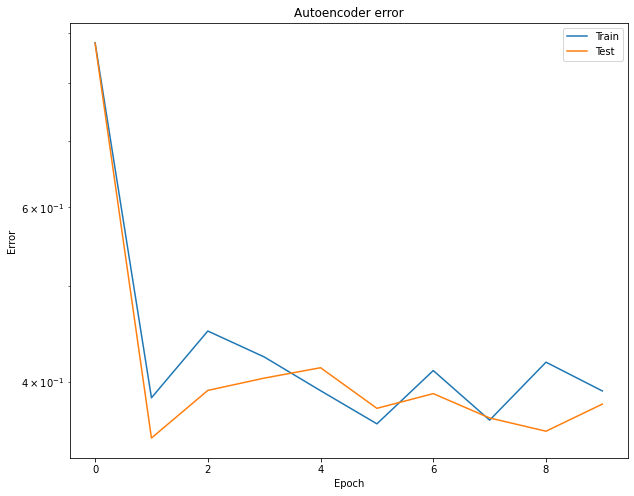

0.3800161567133314

In [97]:
learningRate = 1e-3
epochs= 10
input_size=x_train.shape[1]
k_folds = 5
criterion = nn.MSELoss()  
dataset_name = "middle_small" #Only used to save the plot with the good name
Kfold(x_train, k_folds, input_size, epochs, criterion, learningRate, neuron=5, momentum=0.9, comment = True)

#### Parameters tuning

Find the best learning rate of our model using cross-validation.

In [86]:
# define network parameters
learning_rates =[1e-2, 1e-3, 1e-4, 1e-5]
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Learning rate =  0.01

Performance of 5 fold cross validation: 
Average Training Error: 10512.464 	 Average Test Error: 10685.136
 
Learning rate =  0.001

Performance of 5 fold cross validation: 
Average Training Error: 0.392 	 Average Test Error: 0.380
 
Learning rate =  0.0001

Performance of 5 fold cross validation: 
Average Training Error: 0.389 	 Average Test Error: 0.380
 
Learning rate =  1e-05

Performance of 5 fold cross validation: 
Average Training Error: 0.948 	 Average Test Error: 0.947
 

Best learning rate is  0.0001  with a best error of :  0.3797835463868534



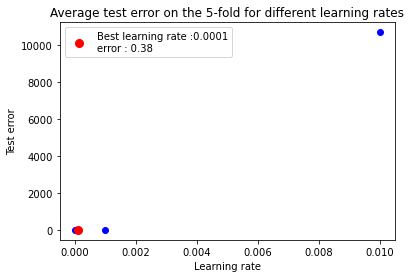

In [98]:
best_result, best_lr = tuning_lr(x_train, k_folds, input_size, epochs, criterion, learning_rates,  dataset_name_=dataset_name)

Find the best number of neurons in the latent space (neurons in the "middle layer of the auto-encoder") in the auto-encoder (which is actually the dimension of the compressed data).

In [99]:
# define network parameters
lr = best_lr # from above
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
number_neurons = [3, 4, 5, 6, 7, 8, 9, 10]
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Number of neurons =  3

Performance of 5 fold cross validation: 
Average Training Error: 0.414 	 Average Test Error: 0.397
 
Number of neurons =  4

Performance of 5 fold cross validation: 
Average Training Error: 0.379 	 Average Test Error: 0.471
 
Number of neurons =  5

Performance of 5 fold cross validation: 
Average Training Error: 0.413 	 Average Test Error: 0.367
 
Number of neurons =  6

Performance of 5 fold cross validation: 
Average Training Error: 0.389 	 Average Test Error: 0.392
 
Number of neurons =  7

Performance of 5 fold cross validation: 
Average Training Error: 0.456 	 Average Test Error: 0.397
 
Number of neurons =  8

Performance of 5 fold cross validation: 
Average Training Error: 0.375 	 Average Test Error: 0.349
 
Number of neurons =  9

Performance of 5 fold cross validation: 
Average Training Error: 0.393 	 Average Test Error: 0.421
 
Number of neurons =  10

Performance of 5 fold cross validation: 
Average Training Error: 0.455 	 Average Test Error: 0.462
 

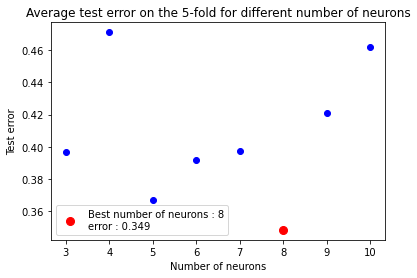

In [100]:
best_result, best_neurons_nb = tuning_latent_layer(x_train, k_folds, input_size, epochs, criterion, lr, number_neurons,  dataset_name_=dataset_name)

#### Let's try with the tuned parameters and see how it goes along the epochs

In [101]:
# define network parameters
learningRate= best_lr
epochs=50
input_size=x_train.shape[1]
k_folds = 3
neuron_ = best_neurons_nb

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:0.991 Test Error:0.990
Epoch:2/50 Training Error:0.939 Test Error:0.940
Epoch:3/50 Training Error:0.837 Test Error:0.840
Epoch:4/50 Training Error:0.697 Test Error:0.680
Epoch:5/50 Training Error:0.558 Test Error:0.529
Epoch:6/50 Training Error:0.390 Test Error:0.507
Epoch:7/50 Training Error:0.294 Test Error:0.366
Epoch:8/50 Training Error:0.340 Test Error:0.316
Epoch:9/50 Training Error:0.628 Test Error:0.433
Epoch:10/50 Training Error:0.428 Test Error:0.453
Epoch:11/50 Training Error:0.454 Test Error:0.391
Epoch:12/50 Training Error:0.539 Test Error:0.366
Epoch:13/50 Training Error:0.339 Test Error:0.345
Epoch:14/50 Training Error:0.393 Test Error:0.318
Epoch:15/50 Training Error:0.342 Test Error:0.463
Epoch:16/50 Training Error:0.338 Test Error:0.364
Epoch:17/50 Training Error:0.291 Test Error:0.387
Epoch:18/50 Training Error:0.453 Test Error:0.418
Epoch:19/50 Training Error:0.330 Tes

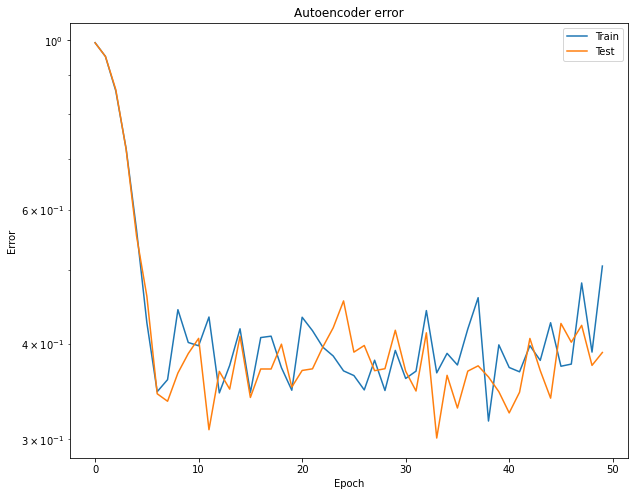

0.38999193462642817

In [102]:
Kfold(x_train, k_folds, input_size, epochs, criterion, learningRate, neuron=neuron_)

#### Quality of the compression on the test set using the tuned parameters

We will now train and test our auto-encoder for different sample size of our initial dataset. To do so we will do a batch processing and store the final train and test errors. See the report to see the nice comparison table.

In [106]:
import glob
import os 
import _pickle as cPickle

dataset = 'middle_small'
file_location = os.path.join('data', 'pickle', dataset, '*')
filenames = glob.glob(file_location)
i=0 


# define the parameters of the model
learningRate= best_lr
neuron_ = best_neurons_nb

epochs=50
criterion = nn.MSELoss() 

test_errors = []
train_errors = []
names = [] #Just to be sure of which error corresponds to which sub-dataset

for f in filenames:
    
    print("\033[1m" +'Train/Test of the sub-dataset ' + f + "\033[0m")
    
    #Load the data
    x  = cPickle.load(open(f, "rb"))
    
    #Split
    x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed)
    y_train, y_test = x_train, x_test
    
    #Declare the model
    input_size=x_train.shape[1]
    model = Autoencoder(input_size, neuron_)
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-5)
    
    #Dataloader
    train_loader = DataLoader(x_train)
    test_loader = DataLoader(x_test)
    
    #Training and testing over the epochs
    for epoch in range(epochs):
        # train the model 
        train_loss=train_epoch(train_loader, model, criterion, optimizer)
        # compute the relative training error
        train_error = valid_epoch(train_loader, model)
        # compute the relative test error
        test_error=valid_epoch(test_loader, model)
        
        print("Epoch:{}/{} Training Error:{:.3f} Test Error:{:.3f}".format(epoch + 1,epochs,train_error,test_error))
    
    #Save the last epoch train and test errors
    test_errors.append(test_error)
    train_errors.append(train_error)
    names.append(f)

Train/Test of the sub-dataset data/pickle/middle_small/processed_middle_small_0.02_0.5
Epoch:1/50 Training Error:0.076 Test Error:0.081
Epoch:2/50 Training Error:0.076 Test Error:0.081
Epoch:3/50 Training Error:0.069 Test Error:0.074
Epoch:4/50 Training Error:0.017 Test Error:0.017
Epoch:5/50 Training Error:0.015 Test Error:0.015
Epoch:6/50 Training Error:0.015 Test Error:0.015
Epoch:7/50 Training Error:0.015 Test Error:0.015
Epoch:8/50 Training Error:0.015 Test Error:0.015
Epoch:9/50 Training Error:0.015 Test Error:0.015
Epoch:10/50 Training Error:0.015 Test Error:0.015
Epoch:11/50 Training Error:0.015 Test Error:0.015
Epoch:12/50 Training Error:0.015 Test Error:0.015
Epoch:13/50 Training Error:0.015 Test Error:0.015
Epoch:14/50 Training Error:0.015 Test Error:0.015
Epoch:15/50 Training Error:0.015 Test Error:0.015
Epoch:16/50 Training Error:0.015 Test Error:0.015
Epoch:17/50 Training Error:0.015 Test Error:0.015
Epoch:18/50 Training Error:0.015 Test Error:0.015
Epoch:19/50 Training E

Epoch:8/50 Training Error:0.016 Test Error:0.017
Epoch:9/50 Training Error:0.016 Test Error:0.017
Epoch:10/50 Training Error:0.017 Test Error:0.017
Epoch:11/50 Training Error:0.016 Test Error:0.017
Epoch:12/50 Training Error:0.016 Test Error:0.016
Epoch:13/50 Training Error:0.016 Test Error:0.017
Epoch:14/50 Training Error:0.016 Test Error:0.017
Epoch:15/50 Training Error:0.016 Test Error:0.017
Epoch:16/50 Training Error:0.016 Test Error:0.017
Epoch:17/50 Training Error:0.016 Test Error:0.017
Epoch:18/50 Training Error:0.017 Test Error:0.018
Epoch:19/50 Training Error:0.021 Test Error:0.023
Epoch:20/50 Training Error:0.017 Test Error:0.017
Epoch:21/50 Training Error:0.017 Test Error:0.018
Epoch:22/50 Training Error:0.016 Test Error:0.016
Epoch:23/50 Training Error:0.016 Test Error:0.016
Epoch:24/50 Training Error:0.015 Test Error:0.016
Epoch:25/50 Training Error:0.015 Test Error:0.015
Epoch:26/50 Training Error:0.014 Test Error:0.015
Epoch:27/50 Training Error:0.012 Test Error:0.013
Ep

Epoch:17/50 Training Error:0.015 Test Error:0.015
Epoch:18/50 Training Error:0.015 Test Error:0.015
Epoch:19/50 Training Error:0.015 Test Error:0.015
Epoch:20/50 Training Error:0.015 Test Error:0.015
Epoch:21/50 Training Error:0.015 Test Error:0.015
Epoch:22/50 Training Error:0.018 Test Error:0.019
Epoch:23/50 Training Error:0.015 Test Error:0.015
Epoch:24/50 Training Error:0.016 Test Error:0.017
Epoch:25/50 Training Error:0.015 Test Error:0.015
Epoch:26/50 Training Error:0.015 Test Error:0.015
Epoch:27/50 Training Error:0.015 Test Error:0.015
Epoch:28/50 Training Error:0.015 Test Error:0.015
Epoch:29/50 Training Error:0.014 Test Error:0.014
Epoch:30/50 Training Error:0.015 Test Error:0.015
Epoch:31/50 Training Error:0.014 Test Error:0.014
Epoch:32/50 Training Error:0.015 Test Error:0.015
Epoch:33/50 Training Error:0.014 Test Error:0.014
Epoch:34/50 Training Error:0.016 Test Error:0.016
Epoch:35/50 Training Error:0.015 Test Error:0.015
Epoch:36/50 Training Error:0.015 Test Error:0.015


In [107]:
from pandas import *

#If you want to load the test and train errors from the saved pickles files, uncomment following lines :
'''
dataset = "middle_small"
train_errors  = cPickle.load(open("data/pickle/results/"+"train_errors_" + dataset, "rb"))
test_errors  = cPickle.load(open("data/pickle/results/"+"test_errors_" + dataset, "rb"))
'''

results = DataFrame({'' : ['50%', '25%', '10%'],
                   '10%' : test_errors[:3][::-1],
                   '5%' : test_errors[3:6][::-1],
                   '2%' : test_errors[6:9][::-1]})

results = results.set_index('')

display(results)
print("\033[1m" + 'Table of relative error depending on the sampling of the dataset' + "\033[0m")
print('x : sampling of times')
print('y : sampling of positions')

,10%,5%,2%
,,,
50%,0.007399,0.008211,0.007557
25%,0.006007,0.013739,0.008072
10%,0.008849,0.007709,0.007796


Table of relative error depending on the sampling of the dataset
x : sampling of times
y : sampling of positions


In [108]:
#Save in pickles
name = "train_errors_" + dataset
cPickle.dump( train_errors , open( name, "wb" ) )
name = "test_errors_" + dataset
cPickle.dump( test_errors , open( name, "wb" ) )

## 5. Physical interpretation <a name="physical"></a>

After compressing our data with the help of the feed-forward encoder, we can investigate if there exists a relationship between the latent neurons and the initial physical parameters.

##### Extract the output of the encoder (X_compressed)

In [42]:
import _pickle as cPickle

# define the parameters of the model
learningRate= 1e-4
neuron_ = 8
epochs=1
criterion = nn.MSELoss() 


#Load the data
x  = cPickle.load(open('data/pickle/middle_small/processed_middle_small_0.1_0.25', "rb"))

#Split
x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed, shuffle=False)
y_train, y_test = x_train, x_test

#Declare the model
input_size=x_train.shape[1]
model = Autoencoder(input_size, neuron_)
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-5)

#Dataloader
train_loader = DataLoader(x_train, batch_size=20)
test_loader = DataLoader(x_test, batch_size=20)

#Training and testing over the epochs
for epoch in range(epochs):
    # train the model 
    train_loss=train_epoch(train_loader, model, criterion, optimizer)
    # compute the relative training error
    train_error = valid_epoch(train_loader, model)
    # compute the relative test error
    test_error=valid_epoch(test_loader, model)

    print("Epoch:{}/{} Training Error:{:.3f} Test Error:{:.3f}".format(epoch + 1,epochs,train_error,test_error))

#Extract the compression
compressed_X_train = []
for train in train_loader :
    train = train.float()
    compressed_x_train = model.forward(x=train, show_compression=True)
    compressed_X_train.append(compressed_x_train.detach().numpy())

compressed_X_test = []    
for test in test_loader :
    test = test.float()
    compressed_x_test = model.forward(x=test, show_compression=True)
    compressed_X_test.append(compressed_x_test.detach().numpy())       

Epoch:1/1 Training Error:0.988 Test Error:0.988


In [43]:
comp_X_train = np.concatenate(np.squeeze(np.array(compressed_X_train)))
comp_X_test = (np.squeeze(np.array(compressed_X_test)))

In [44]:
print(comp_X_train.shape)
print(comp_X_test.shape)

(157, 8)
(18, 8)


##### Correlation between the neurons

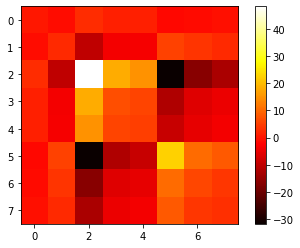

In [45]:
import seaborn as sns

corr = np.cov(comp_X_train.T)

# plot the heatmap
plt.imshow(corr,cmap='hot',interpolation='nearest')
plt.colorbar()
plt.show()

##### Load the real parameters that generated the solutions of the heamodynamic equation

In [46]:
compressed_Y_pd = pd.read_csv("Data/params_middle_small.csv.bz2", header=None)
comp_Y = compressed_Y_pd.to_numpy()

In [47]:
comp_Y.shape

(175, 5)

In [48]:
comp_Y_train, comp_Y_test = train_test_split(comp_Y, test_size=0.1, random_state=seed, shuffle=False)
comp_Y_test.shape

(18, 5)

##### Regression model

Feature engineering : Polynomial extension 

In [49]:
exponents = np.arange(3) + 1

comp_X_train_pol = []
for row in comp_X_train: 
    comp_X_train_pol.append((row**exponents[:,None]).ravel())
    
comp_X_test_pol = []
for row in comp_X_test: 
    comp_X_test_pol.append((row**exponents[:,None]).ravel())      

In [50]:
from sklearn.linear_model import LinearRegression
reg_pol = LinearRegression().fit(comp_X_train, comp_Y_train)
train_score = (reg_pol.score(comp_X_train, comp_Y_train))
test_score = (reg_pol.score(comp_X_test, comp_Y_test))
print('The train score is: ', train_score)
print('The test score is: ', test_score)

The train score is:  0.7138676581991483
The test score is:  0.5798980031490466


In [51]:
from sklearn.linear_model import Ridge
ridge_pol = Ridge(alpha=1).fit(comp_X_train_pol, comp_Y_train)
train_score_ridge = (ridge_pol.score(comp_X_train_pol, comp_Y_train))
test_score_ridge = (ridge_pol.score(comp_X_test_pol, comp_Y_test))
print('The train score is: ', train_score_ridge)
print('The test score is: ', test_score_ridge)

The train score is:  0.6801010426987691
The test score is:  0.5187052708142683


In [52]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0, alpha=1).fit(comp_X_train, comp_Y_train)
train_score_elast = (regr.score(comp_X_train, comp_Y_train))
test_score_elast = (regr.score(comp_X_test, comp_Y_test))
print('The train score is: ', train_score_elast)
print('The test score is: ', test_score_elast)

The train score is:  0.2908019874602393
The test score is:  0.29012450348332575


In [44]:
epochs_ =100

test_scores, test_scores_ridge, train_scores, train_scores_ridge = physical_params_pipeline(dataset_name= 'data/pickle/middle_small/processed_middle_small_0.1_0.25', 
                                                                                            params_name= "Data/params_middle_small.csv.bz2", epochs=epochs_, degree=3, 
                                                                                            alpha_=1, seed=seed)


Epoch:1/100 Training Error:0.976 Test Error:0.976

For the simple regression model : 
The train score is:  0.6806507667460261
The test score is:  0.5742103936974374
For the Ridge regression model : 
The train score is:  0.6972016638983489
The test score is:  0.5325861216063941


Epoch:2/100 Training Error:0.865 Test Error:0.864

For the simple regression model : 
The train score is:  0.6548686308318109
The test score is:  0.5952065999463756
For the Ridge regression model : 
The train score is:  0.743049322933033
The test score is:  0.5398662093240851


Epoch:3/100 Training Error:0.656 Test Error:0.654

For the simple regression model : 
The train score is:  0.6902067168138997
The test score is:  0.5591082733002855
For the Ridge regression model : 
The train score is:  0.7699078192657989
The test score is:  0.622052408121221


Epoch:4/100 Training Error:0.424 Test Error:0.420

For the simple regression model : 
The train score is:  0.7100087837411824
The test score is:  0.5412355987535


Epoch:28/100 Training Error:0.062 Test Error:0.041

For the simple regression model : 
The train score is:  0.7303710223656298
The test score is:  0.6003944710882511
For the Ridge regression model : 
The train score is:  0.7851390579860824
The test score is:  0.6307592280427655


Epoch:29/100 Training Error:0.053 Test Error:0.035

For the simple regression model : 
The train score is:  0.73051029975381
The test score is:  0.603968237692945
For the Ridge regression model : 
The train score is:  0.7877354112038113
The test score is:  0.6387344770981708


Epoch:30/100 Training Error:0.044 Test Error:0.029

For the simple regression model : 
The train score is:  0.7303786583434199
The test score is:  0.6065003847662404
For the Ridge regression model : 
The train score is:  0.790168853532214
The test score is:  0.6447447883813942


Epoch:31/100 Training Error:0.035 Test Error:0.023

For the simple regression model : 
The train score is:  0.7295244683191718
The test score is:  0.60734241002


Epoch:55/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7275192345488619
The test score is:  0.6195703437608507
For the Ridge regression model : 
The train score is:  0.8239203026605709
The test score is:  0.6806960152267838


Epoch:56/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7276588470510965
The test score is:  0.6190568305886032
For the Ridge regression model : 
The train score is:  0.8244765703876478
The test score is:  0.6809860656397401


Epoch:57/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7277174481283283
The test score is:  0.6187631709279113
For the Ridge regression model : 
The train score is:  0.8250928988320357
The test score is:  0.6812205622239332


Epoch:58/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7277776429004762
The test score is:  0.6184349


Epoch:82/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7273717605363449
The test score is:  0.6096794880651761
For the Ridge regression model : 
The train score is:  0.8354478518746051
The test score is:  0.6866705050955645


Epoch:83/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7267263712866194
The test score is:  0.6085678904800293
For the Ridge regression model : 
The train score is:  0.8360048171627301
The test score is:  0.6871661324695125


Epoch:84/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7261528377715034
The test score is:  0.6077368332844195
For the Ridge regression model : 
The train score is:  0.8363571839376231
The test score is:  0.6878079405270282


Epoch:85/100 Training Error:0.010 Test Error:0.007

For the simple regression model : 
The train score is:  0.7257966683486964
The test score is:  0.6073029

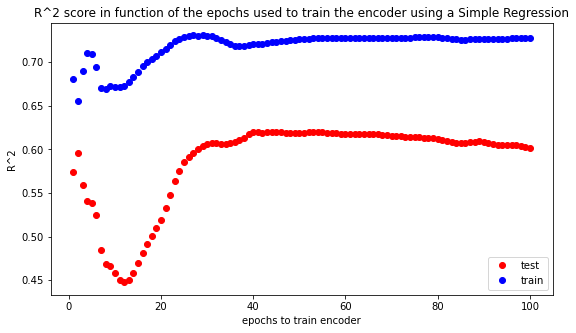

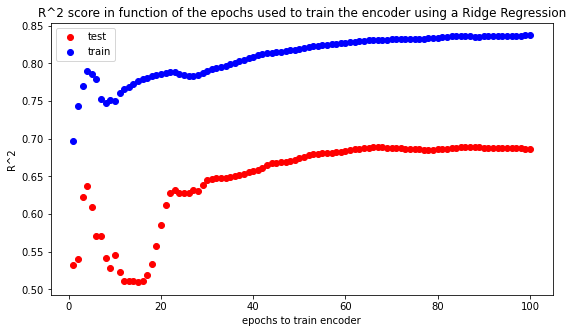

In [45]:
plot_regression_epochs(epochs_, test_scores, train_scores, method_name='Simple Regression') 
plot_regression_epochs(epochs_, test_scores_ridge, train_scores_ridge, method_name='Ridge Regression')

## 6. Discussion & conclusion <a name="ccl"></a>